# this notebook contains the following sections :
## 1. prepare dataset for speech emotion recognition 
## 2. build a transformer encoder classifier
## 3. training the model on initial hyperparameters

## section 1: prepare the dataset
we will use a famous dataset [IEMOCAP] for speech emotion recognition in order to assess the performance of our model, and then we try to fine-tune it on the actual final dataset.
[IEMOCAP] consists of 5 acted sessions of speech, each including a range of 9 emotions, in a total of 12 hours of speech, divided into sentences (each of 3 seconds max).
each sentence is annotated by experts and clissified into one of many emotions : anger, happiness, sadness, neutral ..
 
 first, we will prepare folder tree, we implement this by copying necessary audio files (sentences) from the dataset into a specified directory (TARGET_PATH). folder tree is as follows:
    
    root:
    ---- /IEMOCAP
    ---- ---- /Session1
    ---- ---- ---- /EmoEval
    ---- ---- ---- /Sentences
    ---- ---- /Session2
    ---- ---- ---- /EmoEval
    ---- ---- ---- /Sentences
    ---- ---- /Session3
    ---- ---- ---- /EmoEval
    ---- ---- ---- /Sentences
    ---- ---- /Session4
    ---- ---- ---- /EmoEval
    ---- ---- ---- /Sentences
    ---- ---- /Session5
    ---- ---- ---- /EmoEval
    ---- ---- ---- /Sentences

    

In [40]:
#first we need to import all necessary packages

import json
import os
import re
import tqdm
import shutil
import librosa
import torchaudio
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import torch.nn as nn
from torchsummary import summary
import torch.utils.data as torchdata 
import torch.optim
import torch.nn.functional as F
import time 
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


#constant files are global UPPERCASE
TARGET_PATH = "../Datasets/IEMOCAP"
SRC_PATH = "../Datasets/IEMOCAP_full_release"

def prepare_directory(src_dataset, trg_dataset):
    """
    prepare dataset_folder as folllow:
    trg_dataset contains 5 sessions, each session folder containes 2 subfolders : EmoEval, Sentences
    - EmoEval has the values of (filename, emotion label)
    - Sentences containes the .wav files 
    """
    os.makedirs(trg_dataset, exist_ok=True)
    for dir_path, dir_names, filenames in os.walk(src_dataset):
        folder_names = dir_path.split(sep="/")
        
        if folder_names[-1] == "EmoEvaluation":
            for file in filenames:
                target_path = os.path.join(trg_dataset,folder_names[-3],"EmoEval")
                os.makedirs(target_path, exist_ok=True)
                current_path = os.path.join(dir_path, file)
                shutil.copy(current_path, target_path)
                
                
        if folder_names[-2] == "sentences" and folder_names[-1] == 'wav':
            target_path = os.path.join(trg_dataset,folder_names[-3],"Sentences")
            for d in dir_names:
                current_path = os.path.join(dir_path, d)
                shutil.copytree(current_path, target_path, symlinks=False, ignore=None, ignore_dangling_symlinks=False, dirs_exist_ok=True)

    
prepare_directory(SRC_PATH, TARGET_PATH)

 9 target classification were recorded in the dataset, first we will enumerate them to get a dictionary {emotion : label }

In [41]:
y = "angry, happy, sad, neutral, frustrated, excited, fearful, disgusted, other".split(",")
y = sorted(y)
y = [i.strip() for i in y]
x = [f[0:3] for f in y]
x = dict.fromkeys(x)
for i, j in enumerate(x.keys()):
    x[j] = i
    
label_index = x


In [43]:
#prepare json file that stores filenames, genders, and labels from all sessions of the dataset


ROOT_PATH = "../Datasets/IEMOCAP"
JSON_PATH = "../Datasets/IEMOCAP/json/data.json"


def prepare_json(src_path, trg_path):
    '''read dataset folder to extract a json file containing the filenames, gender, and label of each sentence'''
        
    
    global filenames_labels
    filenames_labels = {
        "filenames" : [],
        "genders" : [],
        "labels" : []
    }
    
    
    for dir_path, dir_names, filenames in os.walk(src_path):
        # if current dir is Session_i      
        folder_names = dir_path.split(sep="/")
        if folder_names[-1] == "EmoEval":
            for f in tqdm.tqdm(filenames, desc="Reading Folder: {}".format(dir_path), ncols=140):
                if f.split(".")[-1] == "txt":
                    current_path = os.path.join(dir_path, f)
                    with open(current_path, "r") as fr:
                        for l in fr:
                            reg = re.findall("\[\d+.\d+ \- \d+.\d+\]", l)
                            
                            if reg is not None:
                                splits = l.split()
                                if len(splits) < 5:
                                    continue
                                sentence_path = splits[3]
                                emo = splits[4]
                                
                                if emo in label_index:
                                    track_path = os.path.join(dir_path, '../Sentences', sentence_path + ".wav")
                                  
                                    try:
                                        librosa.load(track_path)
                                        filenames_labels["filenames"].append(track_path)
                                        filenames_labels["genders"].append(sentence_path[-4])
                                        filenames_labels["labels"].append(label_index[emo])
                                    except:
                                         pass
                                
        if dir_path.split(sep="/")[-1][:-1] == "Session" :
            session_number = dir_path.split(sep="/")[-1][-1]
            current_path = os.path.join(dir_path, 'dialog/EmoEvaluation/Categorical')
    
    os.makedirs(os.path.dirname(track_path), exist_ok=True)
    os.makedirs(os.path.dirname(trg_path), exist_ok=True)
    with open(trg_path, 'w+') as fp:
        json.dump(filenames_labels, fp, indent=4)
    
    
    print("output location: {}".format(trg_path))
    return filenames_labels["labels"]
        

    
files = prepare_json(ROOT_PATH, JSON_PATH)



Reading Folder: ../Datasets/IEMOCAP/Session3/EmoEval: 100%|█████████████████████████████████████████████████| 32/32 [00:01<00:00, 19.29it/s]
Reading Folder: ../Datasets/IEMOCAP/Session5/EmoEval:   6%|███▏                                              | 2/31 [00:00<00:01, 19.37it/s]/tmp/ipykernel_12354/570616211.py:42: UserWarning: PySoundFile failed. Trying audioread instead.
  librosa.load(track_path)
Reading Folder: ../Datasets/IEMOCAP/Session5/EmoEval: 100%|█████████████████████████████████████████████████| 31/31 [00:01<00:00, 22.88it/s]
Reading Folder: ../Datasets/IEMOCAP/Session4/EmoEval: 100%|█████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.59it/s]
Reading Folder: ../Datasets/IEMOCAP/Session1/EmoEval: 100%|█████████████████████████████████████████████████| 28/28 [00:01<00:00, 19.66it/s]
Reading Folder: ../Datasets/IEMOCAP/Session2/EmoEval: 100%|█████████████████████████████████████████████████| 30/30 [00:01<00:00, 20.37it/s]

output location: ../Datasets/IEMOCAP/json/data.json


now we have our json file, which contains filepaths and labels of each audio segment

In [47]:
assert len(files) > 0, print('json file is empty!') # to make sure that everything is fine 
len(files)

7135

### - feature extraction:

numerous options can be used as features for audio signals, such as MFCC, mel-bins, Delta_MFCC, Spectogram .. 
we can experiment with different features after building the model. For now we will implement two feature-extracting functions: 
1. extracts MFCC + Delta_MFCC for a total of 26-dim features vector for each stride of audio
(def 'extract_MFCC_delta'). 
2. extracts mel-bins features for a total of 64-dim feature vector for each strided of audio
(def 'extract_mel_bins')





audio data preprocessing consists of : voice activity detection to remove silences from beginning and end of each audio utterance. then data-segmenting to obtain fixed-length audio utterances as inputs. Each utterance is windowed into many segments 

we will adapt similar approach to : 
@ARTICLE{gong_psla, 
    author={Gong, Yuan and Chung, Yu-An and Glass, James},  
    journal={IEEE/ACM Transactions on Audio, Speech, and Language Processing},   
    title={PSLA: Improving Audio Tagging with Pretraining, Sampling, Labeling, and Aggregation},   
    year={2021}, 
    doi={10.1109/TASLP.2021.3120633}
}

In [46]:
def extract_MFCC_delta(waveform, sr, win_size=0.025, stride=0.01, n_mfcc=13):
    """
     extract 13 MFCC + 13 Delta_MFCC as low level descriptors 
    :param track_path: path of the audio track
    :param win_size: length of the hamming window (in seconds)
    :param stride: stride length (in seconds)
    :param n_mfcc: number of desired mel frequency cepstral coefficients
    :returns : spectogram of mfcc+elta features
    """
    
    #specifty parameters of mfcc
    n_fft = int(win_size*sr)
    hop_length = int(stride*sr)
    
    # get mfcc, deltas 
    MFCC = librosa.feature.mfcc(y=waveform,
                                n_mfcc=n_mfcc,
                                n_fft=n_fft,
                                hop_length=hop_length)
    
    MFCC_delta = librosa.feature.delta(MFCC)
    #librosa.display.specshow(MFCC, x_axis="time")
    #plt.colorbar()
    #plt.xlabel('time')
    #plt.ylabel('MFCC')
    
    MFCC = MFCC
    MFCC_delta = MFCC_delta
    
    features = np.vstack((MFCC, MFCC_delta))
    print("features shape is : {}".format(features.shape))
    return features

In [62]:

def extract_mel_bins(waveform, sr, win_size=0.025, stride=0.01, n_mels= 64):
    '''extract MEL frequency bins as features of the waveform'''
    mel_spectorgram = torchaudio.transforms.MelSpectrogram(sample_rate=sr,
                                                    n_fft=int(win_size*sr),
                                                   hop_length=int(stride*sr),
                                                   n_mels= n_mels)
    features = mel_spectorgram(waveform)
    features = np.array(features)
    features = np.squeeze(features, axis=0)
    return features

waveform, sr = torchaudio.load("/home/bashar/Study/Research_SER/Notebook/Ses03F_impro01_F004.wav")
extract_mel_bins(waveform, sr).shape

(64, 364)

next, we want to process waveforms inside a torch dataset, the following class extracts waveforms from json file, resamples each waveform into a unified sample rate, and fix the length of all wave forms by zero padding. Finally, it extracts features of the waveform by calling a feature extraction user-defined function (here we used mel-bins features which are extracted by caling 'extract_mel_bins')

In [49]:


SAMPLE_RATE=22050
NUM_SAMPLES = 3 * SAMPLE_RATE
JSON_PATH = "../Datasets/IEMOCAP/json/data.json"

class SER_dataset(Dataset):
    def pad_cut_if_necessary(self, waveform):
        # check length of wave form
        wav_length = waveform.shape[1]
        
        # if longer, cut the waveform
        if wav_length > self.num_samples:
            waveform = waveform[:, :self.num_samples]
            
        # if shorter, pad the waveform with zeros
        if wav_length < self.num_samples:
            num_missing_samples = self.num_samples - wav_length
            waveform = torch.nn.functional.pad(waveform, (0, num_missing_samples))
   
        return waveform
  
    
    def __init__(self, json_config_file, transformation,  num_samples=NUM_SAMPLES):
        """
        :param json_config_file : .json file which includes tracks paths and their labels
        :param transformation : a function pointer that will be used to extract features from input audio signals
        :num_samples : total number of samples allowed for the input"""
        with open(json_config_file, 'r') as pf:
            data = json.load(pf)
            
        self.filenames = data["filenames"]
        self.labels = data["labels"]
        self.num_samples = num_samples
        self.transformation = transformation
        
    def __getitem__(self, index):
        
        # get waveform from current index
        waveform, sr = torchaudio.load(self.filenames[index])
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq= SAMPLE_RATE)
        waveform = resampler(waveform)
        waveform = (waveform)
        waveform = self.pad_cut_if_necessary(waveform)
        features = self.transformation(waveform, sr)
        
        # get label of the current index
        label = self.labels[index]
        
        return features, label
        
        
    def __len__(self):
        return len(self.filenames)
            



In [59]:
# define our set of (features, targets) 
my_set = SER_dataset(JSON_PATH, transformation=extract_mel_bins)
print(f"each input is of shape: {my_set[0][0].shape}")

each input is of shape: (64, 414)


## section 2. build a transformer encoder classifier

### this section covers the architecture for the classifier. Which is based on a transformer model that uses multi-head attention.

this layer applies 1d convolution on the spectogram, to get the embeddings of each frame

In [66]:


class input_embedding(nn.Module):
    def __init__(self, d_input, d_model, stride=10, kernel_size=16):
        """
        :param d_input: feature-vector dimension of input spectogram
        :param d_model: output dimension of the embeddings
        """
        super().__init__()
        self.proj = nn.Conv2d(1, d_model, kernel_size=(d_input, kernel_size), stride=stride)

    def forward(self, x):
        """
        :param x: input of shape [B, d_input, t_length]
        return : output of shape [B, max_length, d_model]"""
        # we need to add new axis for number of channels
        x = torch.unsqueeze(x, dim=1)
        # we apply the projection layer
        x = self.proj(x)
        # we remove the height dimension, because it is always equal to 1 
        x = torch.squeeze(x, dim=2)
        #x = torch.einsum('bij->bji', x)
        x = x.transpose(1,2)
        return x

    
inp = torch.randn([5, 64, 414])
embed = input_embedding(64, 128)
summary(embed, (64, 414))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 128, 1, 40]         131,200
Total params: 131,200
Trainable params: 131,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.10
Forward/backward pass size (MB): 0.04
Params size (MB): 0.50
Estimated Total Size (MB): 0.64
----------------------------------------------------------------


now we will work on positional encoding PE, which is added to the output of the projection layer (AKA embeddings) to capture the positional information of the input audio.
the theory behind this positional encoding techniques is derived from the paper "Attention is all you need"

PE(pos,2i) = sin(pos/(1000^(2i/d_model))
PE(pos,2i+1) = cos(pos/(1000^(2i/d_model))

In [70]:
# positional encoding :
from torchsummary import summary

class PositionalEncoding( nn.Module ):
    """
    a nn.Module wrapper to extract Position embeddings with a specific dimnesionality
    """
    def __init__(self,d_model, max_length):
        """
        :param max_length: number of columns of input embedding 
        :param d_model: number of rows to represent input features of the transformer
        """
        super().__init__()
        self.max_length = max_length
        self.d_model = d_model
        
    def forward(self, x):
        # get the length of sequency from input
        seq_len = x.shape[1]
        
        even_i = torch.arange(0, self.d_model, 2).float()
        even_den = pow(10000, even_i/self.d_model)
        pos = torch.arange(seq_len).float().unsqueeze(1)
        
        even_pe = torch.sin(pos/even_den)
        odd_pe = torch.cos(pos/even_den)
        stacked = torch.stack([even_pe, odd_pe], dim=2)
        stacked = torch.flatten(stacked, start_dim=1, end_dim=2)
        return stacked
 
pe = PositionalEncoding(128,40)


Next, we will build the Transformer encoder blocks, which consists of multi-headed attention layer, followed by a feed-forward layer (as in the paper "Attention is all you need")


In [72]:


class MultiHeadSplit(nn.Module):
    """split the input data into multiple heads using linear layers"""
    def __init__(self, d_model:int, d_k:int, heads:int= 8, bias=False):
        """
        :param d_model: input feature dimension
        :param d_k: dimension of each head 
        :param heads: number of heads to split each input sample into
        :param bias: whether to apply bias term into linear layer"""
        super().__init__()
        # copy params into local attributes of the class
        self.d_model = d_model
        self.d_k = d_k
        self.heads = heads

        # assert that numbers check
        assert(self.d_k * self.heads == self.d_model), "heads number isn't compatible with dimesions!"
        
        
        # create a linear layer to create the different heads
        self.linear = nn.Linear(d_model, heads * d_k, bias=bias)
        
    def forward(self, x):
        """x is of shape [-1, seq_length, d_model]"""
        # change the view of the input so that trainable features (d_model) is the last
        shape = x.shape[:-1]
        # split x into multiple heads
        x = self.linear(x)
        
        
        # split last dimension into two 
        x = x.view(*shape, self.heads, self.d_k)
        x = torch.transpose(x, -2, -3)
        

        # return output
        return x
    

In [73]:
mh = MultiHeadSplit(128, 16)
summary(mh, (40, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 40, 128]          16,384
Total params: 16,384
Trainable params: 16,384
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 0.06
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


next, we will create the scaled dot-product attention layer, which will be used to extract meaningful relations between different parts of the audio track

In [74]:
class SelfAttention(nn.Module):
    def __init__(self, d_model, heads, d_k, bias=False, dropout=0.1): # dropout is set randomly 
        super().__init__()
        
        self.d_model = d_model
        self.heads = heads
        self.d_k = d_k
        
        # split input into three matrecies : q: query, k: key, v: value using linear layers
        self.query = MultiHeadSplit(d_model, d_k, heads, bias)
        self.key = MultiHeadSplit(d_model, d_k, heads, bias)
        self.value = MultiHeadSplit(d_model, d_k, heads, bias)
        
        # define necessery activations
        self.softmax = nn.Softmax(dim= -1) # the input to the softmax has shape (t_dim, t_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = 1 / (self.d_k)**(0.5)
        
        output = nn
        
    def get_att(self, q, k):
        """
        q shape (B, h, q_len, d)
        k shape (B, h, k_len, d)
        
        :return : output of shape (B, h, q_len, k_len)
            """
        out = torch.einsum('bhqd,bhkd->bhqk', q, k)
        return out
    
    
    def forward(self, x, mask=None):
        """
        :param x : input of shape (B, seq_length, d_model) 
        :param mask : mask of shape (B, seq_length)
        
        :return output of shape (B, seq_length, d_v)
        """
                
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        
        # apply matmul
        att = self.get_att(q, k)
        
        # apply scale
        att = att * self.scale
        
      
        
        # apply mask
        if mask is not None:
            att = att.masked_fill(mask==0, -1 * torch.inf)
            
        # apply softmax
        att = self.softmax(att)
        
        # apply matmul
        att = torch.einsum('bhqk,bhkd->bqhd', att, v)
        
        # concatenate all heads in one (bhqd -> bq(d*h)
        shape = att.shape[:-2]

        out = att.reshape(*shape, att.shape[-1] * att.shape[-2])

        
        return out
    
  
        
from torchsummary import summary 


        

In [75]:
# next we will implement the feed forward layer 

class FeedForward(nn.Module):
    def __init__(self, d_model, n_hidden, dropout=0.1):
        """
        :param n_hidden number of feed forward features in the hidden layer"""
        super().__init__()
        self.d_model = d_model
        self.n_hidden = n_hidden
        
        # First linear layer
        self.linear1 = nn.Linear(d_model, n_hidden)
        
        #Second Linear layer
        self.linear2 = nn.Linear(n_hidden, d_model)
        
        #dropout layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # apply first linear
        x = self.linear1(x)
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x
    

ff = FeedForward(128, 1024)
summary(ff, (40, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 40, 1024]         132,096
           Dropout-2             [-1, 40, 1024]               0
            Linear-3              [-1, 40, 128]         131,200
Total params: 263,296
Trainable params: 263,296
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.66
Params size (MB): 1.00
Estimated Total Size (MB): 1.69
----------------------------------------------------------------


In [77]:
class LayerNorm(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        self.norm = nn.LayerNorm(normalized_shape=input_shape)
    
    def forward(self, x):
        return self.norm(x)
    
n = LayerNorm((128))
summary(n, (40,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1              [-1, 40, 128]             256
Total params: 256
Trainable params: 256
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [78]:
# now we implement the encoder block 

class EncoderBlock(nn.Module):
    """
    This layer consists of self attention layer, followed by add and norm layer, then a feed forward layer, followed by add and norm layer """
    def __init__(self, d_model, d_k, heads, n_hidden=1024, dropout=0.1, bias=False):
        super().__init__()
        self.d_model = d_model
        self.heads = heads
        self.d_k = d_k
        self.bias = bias
        
        # define a self attention layer
        self.self_attention = SelfAttention(d_model, heads, d_k, bias, dropout)
        
        # norm layer
        self.norm1 = LayerNorm(d_model)
        self.norm2 = LayerNorm(d_model)
        
        # feed forward layer
        self.ff = FeedForward(d_model, n_hidden=n_hidden,dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        
    
    def forward(self, x):
        """
        x has a shape of (B, seq_length, d_model)"""
        
        att = self.self_attention(x)
        
        x = self.norm1(x + att)
        
        x = self.dropout(x)
        ff = self.ff(x)
        
        x = self.norm2(x + ff)
        x = self.dropout(x)
        
        return x
        
        
        
enc = EncoderBlock(128, 16, 8)

summary(enc, (40, 128))
        

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 40, 128]          16,384
    MultiHeadSplit-2            [-1, 8, 40, 16]               0
            Linear-3              [-1, 40, 128]          16,384
    MultiHeadSplit-4            [-1, 8, 40, 16]               0
            Linear-5              [-1, 40, 128]          16,384
    MultiHeadSplit-6            [-1, 8, 40, 16]               0
           Softmax-7            [-1, 8, 40, 40]               0
     SelfAttention-8              [-1, 40, 128]               0
         LayerNorm-9              [-1, 40, 128]             256
        LayerNorm-10              [-1, 40, 128]               0
          Dropout-11              [-1, 40, 128]               0
           Linear-12             [-1, 40, 1024]         132,096
          Dropout-13             [-1, 40, 1024]               0
           Linear-14              [-1, 

In [79]:
# the encoder sonsists of a positional embedding block + sequence of n encoder blocks 


class Encoder(nn.Module):
    def __init__(self, max_length, d_model, d_k, heads,n_encoders=1, n_hidden=1024, dropout=0.1, bias=False ):
        super().__init__()
        
        # self.pe = PositionalEncoding(d_model, max_length)
      
        self.enc_blocks = nn.ModuleList([
            EncoderBlock(d_model, d_k, heads, n_hidden, dropout, bias) for i in range(n_encoders)
        ])
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, x): 
        """x is of shape (B, seq_length, d_model)
        :return output of shape (B, seq_length, d_model)"""

        seq_length = x[1]
        #pe = self.pe()[:seq_length,:]
        # add positional information 
        x = x #+ pe
        
        # inject new input to encoder blocks 
        
        for layer in self.enc_blocks:
            x = layer(x)        
        return x
        
enc = Encoder(40, 128, 16,8)
summary(enc, (40,128))
        

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 40, 128]          16,384
    MultiHeadSplit-2            [-1, 8, 40, 16]               0
            Linear-3              [-1, 40, 128]          16,384
    MultiHeadSplit-4            [-1, 8, 40, 16]               0
            Linear-5              [-1, 40, 128]          16,384
    MultiHeadSplit-6            [-1, 8, 40, 16]               0
           Softmax-7            [-1, 8, 40, 40]               0
     SelfAttention-8              [-1, 40, 128]               0
         LayerNorm-9              [-1, 40, 128]             256
        LayerNorm-10              [-1, 40, 128]               0
          Dropout-11              [-1, 40, 128]               0
           Linear-12             [-1, 40, 1024]         132,096
          Dropout-13             [-1, 40, 1024]               0
           Linear-14              [-1, 

In [80]:
# the full architechture consists of : input embedding + encoder + global average 
# we will experiment with global averaging and cls token [like BERT]


class Classifier(nn.Module):
    def __init__(self, n_classes, d_model, seq_length):
        super().__init__()
        self.average_pooling = nn.AvgPool1d(kernel_size=seq_length, stride=seq_length)
        self.flat = nn.Flatten(start_dim = 1, end_dim=2)
        self.linear = nn.Linear(d_model, n_classes)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
       
        # add channel dimension 
        x = x.unsqueeze(dim=1)
      
        # transpose input 
        x = x.transpose(-1,-2)
        
        # flatten input 
        x = self.flat(x)
    
        # apply avgPool
        x = self.average_pooling(x)
        
        # remove added dimension
        x = x.squeeze(dim=-1)
        
        # apply linear layer 
        x = self.linear(x)
        
        # apply softmax 
        x = self.softmax(x)
        
        return x
    
cls = Classifier(5, 128, 40)
summary(cls, (40, 128))
        

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1              [-1, 128, 40]               0
         AvgPool1d-2               [-1, 128, 1]               0
            Linear-3                    [-1, 5]             645
           Softmax-4                    [-1, 5]               0
Total params: 645
Trainable params: 645
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [82]:
# the full arch consists of : input embedding + encoder + global average 
# we will experiment with global averaging and cls token [like BERT]


class Classifier2(nn.Module):
    def __init__(self, n_classes, d_model, seq_length):
        super().__init__()
        self.linear = nn.Linear(d_model, n_classes)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        # apply linear layer 
        x = self.linear(x)
        
        # apply softmax 
        x = self.softmax(x)
        
        return x
    
cls2 = Classifier2(10, 128, 40)



In [83]:
# we will encapsulate the whole work under one class 

class SERT(nn.Module):
    def __init__(self,d_input,
                 max_length,
                 d_model,
                 d_k,
                 heads,
                 n_classes,
                 n_encoders=1,
                 n_hidden=1024,
                 dropout=0.1,
                 bias=False,
                 stride=10,
                 kernel_size=16 ):
        super().__init__()
        self.input = input_embedding(d_input, d_model, stride, kernel_size)
        self.enc_layers = nn.ModuleList([
            Encoder(max_length,
                    d_model,
                    d_k,
                    heads,
                    n_encoders=1,
                    n_hidden=1024,
                    dropout=0.1,
                    bias=False) for _ in range(n_encoders)
        ])
        self.output= Classifier(n_classes, d_model, max_length)
    
    def forward(self, x):
        x = self.input(x)
        for layer in self.enc_layers:
            x = layer(x)
            
        x = self.output(x)
        return x
        
sert_model = SERT(d_input=64, max_length=35, d_model=128,d_k=16,heads=8,n_classes=9)

        

## section 3. training the model on initial hyperparameters:


In [100]:
# first we will split the dataset into train_test_validation sets 


def train_test_val_split(dataset, train_test,train_val):
    """splits dataset into 3 groups:
    1- train dataset (size = train_test*train_val)
    2 - test dataset (size = (1-train_test))
    3- validation dataset (size = (train_test * (1-train_val))
    """

    train_ds, test_ds = torchdata.random_split(dataset, [int(train_test * len(dataset)), len(dataset) - int(train_test * len(dataset))])
    train_ds, val_ds = torchdata.random_split(train_ds, [int(train_val * len(train_ds)), len(train_ds) - int(train_val * len(train_ds))])
    train_size = train_test * train_val
    test_size = 1 - train_size
    val_size = train_test * (1 - train_val)
    print("dataset is split as follows:\n\ntrain : {}({})\n\ntest : {}({})\n\nvalidation : {}({})".format(len(train_ds), round(train_size,2), len(test_ds), round(test_size, 2), len(val_ds), round(val_size, 2)))
    return train_ds, test_ds, val_ds


train,test,val = train_test_val_split(my_set, 0.8, 0.8)

# after splitting, we will define the dataloader
train_dataloader = torchdata.DataLoader(dataset=train, batch_size=32, shuffle=True)
validation_dataloader = torchdata.DataLoader(dataset=val, batch_size=32, shuffle=True)
test_dataloader = torchdata.DataLoader(dataset=test, batch_size=32, shuffle=True)


# specify the optimizer (adam) and the loss function
optimizer = torch.optim.Adam(sert_model.parameters(), lr=0.0001)


loss_fn = nn.CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

sert_model = sert_model.to(device)


dataset is split as follows:

train : 4566(0.64)

test : 1427(0.36)

validation : 1142(0.16)
cpu


143

### building training loop:

In [158]:


def model_train(model,train_dataset, val_dataset, num_epochs, device, loss_fn, metric, optimizer, ext_dir):
    """returns information about the model, the results of training
    :param ext_dir: directory to save the state of the best performing model according to the metric function
    """
    
    summary = {
        'model name': model.__class__.__name__,
        'device': device,
        'loss_fn': loss_fn,
        'metric': metric, 
        'optimizer':optimizer,
        'num_epochs' : num_epochs,
        'train_loss' :[],
        'train_accuracy': [],
        'val_loss' :[],
        'val_accuracy' :[],
        'steps' :[]
    }
    
    batch_size = train_dataset.batch_size
    
    print(f"start training with :\n total epochs: {num_epochs}\n batch size: {train_dataset.batch_size}\n total batches: {len(train_dataset)}")
    
    # set a timer to measure the training time 
    start_timer = time.time()
    
    
    model = model.to(device)
    
    # log stride = 10% of the number of batches to loop through, this is used to print results while training 
    log_stride = int(0.1 * len(train_dataset))
    
    # add model graph to tensorboard
    batch, _ = next(iter(train_dataset))
    writer = SummaryWriter(f"runs/log_sert_model")
    writer.add_graph(model, batch.to(device))
    
    
    # save the best performing model
    max_acc = 0.0
    
    
    for epoch in tqdm(range(num_epochs)):
        # we will calculate average loss per epoch, average accuracy per epoch
        loss_epoch = 0.0
        accuracy_epoch = 0.0
        
        # average metrics per log_stride
        loss_stride = 0.0
        correct_stride = 0
        
        # save metrics for logging
        train_loss =[]
        train_acc = []
        eval_loss = []
        eval_acc = []
            
        model.train()
        for it, (X, y) in enumerate(train_dataset):
            X = X.to(device)
            y = y.to(device)
            
            y_pred = model(X)
            
            # calculate the loss
            loss =loss_fn(y_pred, y)
            loss_stride += loss
            train_loss.append((loss, epoch, it))
            
            
            # get correct predictions
            predictions = torch.argmax(y_pred, dim=1)
           
            
            correct_stride += (y == predictions).sum().item()
            train_acc.append(((correct_stride)/batch_size, epoch, it))
            
            # zero grad the optim.
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            if (it + 1) % log_stride == 0:
                # print results
                print(f"epoch[{epoch + 1}/{num_epochs}] | batch[{it + 1}/{len(train_dataset)}] train_loss: {loss_stride/ (log_stride):.4f} | accuracy: {correct_stride/(log_stride * batch_size)}")
                
                # send scalars to tensorboard
                writer.add_scalar('train_loss',loss_stride/ (log_stride), epoch * len(train_dataset) + it)
                writer.add_scalar('train accuracy', correct_stride/(log_stride * batch_size), epoch * len(train_dataset) + it)
                
                
                
                # reset parameters
                loss_epoch += loss_stride
                accuracy_epoch += correct_stride
                loss_stride = 0.0
                correct_stride = 0
        
        print("validation:")
        model.eval()
        loss_val = 0.0
        acc_val = 0.0
        
        
        with torch.inference_mode() :
            correct = 0
            for (X_test, y_test) in val_dataset:
                X_test = X_test.to(device)
                y_test = y_test.to(device)
                
                y_pred = model(X_test)
                loss_val += loss_fn(y_pred, y_test)
                predictions = torch.argmax(y_pred, dim=1)
                
                correct += (predictions == y_test).sum().item()
                
        eval_loss.append((loss_val / len(val_dataset), epoch))
        eval_acc.append(((correct/(len(val_dataset) * batch_size)), epoch))
            
        train_accuracy = accuracy_epoch/(batch_size * len(train_dataset))
        print(f"epoch: {epoch} summary:\n train_loss: {loss_epoch / len(train_dataset)}, validation loss: {loss_val / len(val_dataset)}, train accuracy: {accuracy_epoch/(len(train_dataset) * batch_size)}")
        
        summary['train_loss'].append(loss_epoch.item() / len(train_dataset))

        writer.add_scalar('validation_loss',eval_loss[-1][0],  epoch)
        writer.add_scalar('validation_accuracy',eval_acc[-1][0],  epoch)
        
        summary['val_loss'].append(eval_loss[-1][0].item())
        summary['val_accuracy'].append(correct/(len(val_dataset) * batch_size))
        summary['steps'].append(epoch)
        summary['train_accuracy'].append(accuracy_epoch/(batch_size * len(train_dataset)))

        if train_accuracy > max_acc:
            max_acc = train_accuracy
            torch.save(model.state_dict(), ext_dir)
    
    total_time = (time.time() - start_timer)
    summary['total_time'] = total_time
    writer.close()
    return summary

In [169]:
model = SERT(64,40, d_model=128,d_k= 16, heads=8,n_classes=9,n_encoders=1,dropout=0.001, n_hidden=768)
train,test,val = train_test_val_split(my_set, 0.8, 0.8)

# after splitting, we will define the dataloader
train_dataloader = torchdata.DataLoader(dataset=train, batch_size=64)
validation_dataloader = torchdata.DataLoader(dataset=val, batch_size=64, shuffle=True)
test_dataloader = torchdata.DataLoader(dataset=test, batch_size=32, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
summary = model_train(model, train_dataloader, validation_dataloader, num_epochs=20, device=device, loss_fn=loss_fn, metric=loss_fn, optimizer=optimizer, ext_dir='./model')


dataset is split as follows:

train : 4566(0.64)

test : 1427(0.36)

validation : 1142(0.16)
start training with :
 total epochs: 20
 batch size: 64
 total batches: 72


  0%|                                                    | 0/20 [00:00<?, ?it/s]

epoch[1/20] | batch[7/72] train_loss: 2.2020 | accuracy: 0.10714285714285714
epoch[1/20] | batch[14/72] train_loss: 2.1966 | accuracy: 0.15178571428571427
epoch[1/20] | batch[21/72] train_loss: 2.1854 | accuracy: 0.20535714285714285
epoch[1/20] | batch[28/72] train_loss: 2.1819 | accuracy: 0.16071428571428573
epoch[1/20] | batch[35/72] train_loss: 2.1772 | accuracy: 0.19419642857142858
epoch[1/20] | batch[42/72] train_loss: 2.1635 | accuracy: 0.27901785714285715
epoch[1/20] | batch[49/72] train_loss: 2.1557 | accuracy: 0.2700892857142857
epoch[1/20] | batch[56/72] train_loss: 2.1480 | accuracy: 0.28794642857142855
epoch[1/20] | batch[63/72] train_loss: 2.1410 | accuracy: 0.3125
epoch[1/20] | batch[70/72] train_loss: 2.1396 | accuracy: 0.29910714285714285
validation:


  5%|██▏                                         | 1/20 [00:25<07:55, 25.03s/it]

epoch: 0 summary:
 train_loss: 2.108841896057129, validation loss: 2.1283209323883057, train accuracy: 0.2204861111111111
epoch[2/20] | batch[7/72] train_loss: 2.1212 | accuracy: 0.2857142857142857
epoch[2/20] | batch[14/72] train_loss: 2.1277 | accuracy: 0.27901785714285715
epoch[2/20] | batch[21/72] train_loss: 2.1100 | accuracy: 0.3236607142857143
epoch[2/20] | batch[28/72] train_loss: 2.1115 | accuracy: 0.29017857142857145
epoch[2/20] | batch[35/72] train_loss: 2.1172 | accuracy: 0.2700892857142857
epoch[2/20] | batch[42/72] train_loss: 2.0946 | accuracy: 0.2857142857142857
epoch[2/20] | batch[49/72] train_loss: 2.0898 | accuracy: 0.30357142857142855
epoch[2/20] | batch[56/72] train_loss: 2.0811 | accuracy: 0.33482142857142855
epoch[2/20] | batch[63/72] train_loss: 2.0944 | accuracy: 0.3013392857142857
epoch[2/20] | batch[70/72] train_loss: 2.0971 | accuracy: 0.29910714285714285
validation:


 10%|████▍                                       | 2/20 [00:56<08:36, 28.70s/it]

epoch: 1 summary:
 train_loss: 2.0460047721862793, validation loss: 2.0875234603881836, train accuracy: 0.2890625
epoch[3/20] | batch[7/72] train_loss: 2.0775 | accuracy: 0.32589285714285715
epoch[3/20] | batch[14/72] train_loss: 2.0912 | accuracy: 0.30580357142857145
epoch[3/20] | batch[21/72] train_loss: 2.0732 | accuracy: 0.33035714285714285
epoch[3/20] | batch[28/72] train_loss: 2.0825 | accuracy: 0.3125
epoch[3/20] | batch[35/72] train_loss: 2.0924 | accuracy: 0.28794642857142855
epoch[3/20] | batch[42/72] train_loss: 2.0675 | accuracy: 0.30580357142857145
epoch[3/20] | batch[49/72] train_loss: 2.0641 | accuracy: 0.3325892857142857
epoch[3/20] | batch[56/72] train_loss: 2.0543 | accuracy: 0.3482142857142857
epoch[3/20] | batch[63/72] train_loss: 2.0718 | accuracy: 0.30357142857142855
epoch[3/20] | batch[70/72] train_loss: 2.0764 | accuracy: 0.31026785714285715
validation:


 15%|██████▌                                     | 3/20 [01:27<08:28, 29.91s/it]

epoch: 2 summary:
 train_loss: 2.01745343208313, validation loss: 2.069279670715332, train accuracy: 0.3075086805555556
epoch[4/20] | batch[7/72] train_loss: 2.0583 | accuracy: 0.3392857142857143
epoch[4/20] | batch[14/72] train_loss: 2.0769 | accuracy: 0.31026785714285715
epoch[4/20] | batch[21/72] train_loss: 2.0541 | accuracy: 0.3482142857142857
epoch[4/20] | batch[28/72] train_loss: 2.0693 | accuracy: 0.3325892857142857
epoch[4/20] | batch[35/72] train_loss: 2.0786 | accuracy: 0.30580357142857145
epoch[4/20] | batch[42/72] train_loss: 2.0541 | accuracy: 0.3169642857142857
epoch[4/20] | batch[49/72] train_loss: 2.0488 | accuracy: 0.35267857142857145
epoch[4/20] | batch[56/72] train_loss: 2.0380 | accuracy: 0.36160714285714285
epoch[4/20] | batch[63/72] train_loss: 2.0575 | accuracy: 0.3125
epoch[4/20] | batch[70/72] train_loss: 2.0632 | accuracy: 0.3125
validation:


 20%|████████▊                                   | 4/20 [01:58<08:07, 30.46s/it]

epoch: 3 summary:
 train_loss: 2.002669334411621, validation loss: 2.057671546936035, train accuracy: 0.3200954861111111
epoch[5/20] | batch[7/72] train_loss: 2.0450 | accuracy: 0.3549107142857143
epoch[5/20] | batch[14/72] train_loss: 2.0684 | accuracy: 0.3013392857142857
epoch[5/20] | batch[21/72] train_loss: 2.0407 | accuracy: 0.36607142857142855
epoch[5/20] | batch[28/72] train_loss: 2.0609 | accuracy: 0.32589285714285715
epoch[5/20] | batch[35/72] train_loss: 2.0702 | accuracy: 0.30580357142857145
epoch[5/20] | batch[42/72] train_loss: 2.0462 | accuracy: 0.328125
epoch[5/20] | batch[49/72] train_loss: 2.0369 | accuracy: 0.36160714285714285
epoch[5/20] | batch[56/72] train_loss: 2.0274 | accuracy: 0.3705357142857143
epoch[5/20] | batch[63/72] train_loss: 2.0460 | accuracy: 0.3236607142857143
epoch[5/20] | batch[70/72] train_loss: 2.0560 | accuracy: 0.3236607142857143
validation:


 25%|███████████                                 | 5/20 [02:30<07:41, 30.78s/it]

epoch: 4 summary:
 train_loss: 1.9928452968597412, validation loss: 2.0497374534606934, train accuracy: 0.3268229166666667
epoch[6/20] | batch[7/72] train_loss: 2.0375 | accuracy: 0.359375
epoch[6/20] | batch[14/72] train_loss: 2.0624 | accuracy: 0.30357142857142855
epoch[6/20] | batch[21/72] train_loss: 2.0311 | accuracy: 0.3638392857142857
epoch[6/20] | batch[28/72] train_loss: 2.0547 | accuracy: 0.31919642857142855
epoch[6/20] | batch[35/72] train_loss: 2.0630 | accuracy: 0.3236607142857143
epoch[6/20] | batch[42/72] train_loss: 2.0414 | accuracy: 0.33035714285714285
epoch[6/20] | batch[49/72] train_loss: 2.0289 | accuracy: 0.375
epoch[6/20] | batch[56/72] train_loss: 2.0188 | accuracy: 0.37723214285714285
epoch[6/20] | batch[63/72] train_loss: 2.0383 | accuracy: 0.3325892857142857
epoch[6/20] | batch[70/72] train_loss: 2.0485 | accuracy: 0.328125
validation:


 30%|█████████████▏                              | 6/20 [03:01<07:12, 30.91s/it]

epoch: 5 summary:
 train_loss: 1.9857373237609863, validation loss: 2.04314923286438, train accuracy: 0.3318142361111111
epoch[7/20] | batch[7/72] train_loss: 2.0310 | accuracy: 0.35267857142857145
epoch[7/20] | batch[14/72] train_loss: 2.0589 | accuracy: 0.30357142857142855
epoch[7/20] | batch[21/72] train_loss: 2.0235 | accuracy: 0.35714285714285715
epoch[7/20] | batch[28/72] train_loss: 2.0503 | accuracy: 0.3169642857142857
epoch[7/20] | batch[35/72] train_loss: 2.0589 | accuracy: 0.31919642857142855
epoch[7/20] | batch[42/72] train_loss: 2.0358 | accuracy: 0.33035714285714285
epoch[7/20] | batch[49/72] train_loss: 2.0222 | accuracy: 0.37723214285714285
epoch[7/20] | batch[56/72] train_loss: 2.0133 | accuracy: 0.37723214285714285
epoch[7/20] | batch[63/72] train_loss: 2.0327 | accuracy: 0.328125
epoch[7/20] | batch[70/72] train_loss: 2.0443 | accuracy: 0.33035714285714285
validation:


 35%|███████████████▍                            | 7/20 [03:32<06:42, 30.97s/it]

epoch: 6 summary:
 train_loss: 1.9804922342300415, validation loss: 2.0390467643737793, train accuracy: 0.3298611111111111
epoch[8/20] | batch[7/72] train_loss: 2.0256 | accuracy: 0.3482142857142857
epoch[8/20] | batch[14/72] train_loss: 2.0557 | accuracy: 0.3080357142857143
epoch[8/20] | batch[21/72] train_loss: 2.0164 | accuracy: 0.3638392857142857
epoch[8/20] | batch[28/72] train_loss: 2.0471 | accuracy: 0.328125
epoch[8/20] | batch[35/72] train_loss: 2.0553 | accuracy: 0.3125
epoch[8/20] | batch[42/72] train_loss: 2.0319 | accuracy: 0.34375
epoch[8/20] | batch[49/72] train_loss: 2.0154 | accuracy: 0.38392857142857145
epoch[8/20] | batch[56/72] train_loss: 2.0097 | accuracy: 0.3705357142857143
epoch[8/20] | batch[63/72] train_loss: 2.0278 | accuracy: 0.3325892857142857
epoch[8/20] | batch[70/72] train_loss: 2.0397 | accuracy: 0.33035714285714285
validation:


 40%|█████████████████▌                          | 8/20 [04:03<06:12, 31.07s/it]

epoch: 7 summary:
 train_loss: 1.9760117530822754, validation loss: 2.034187078475952, train accuracy: 0.3326822916666667
epoch[9/20] | batch[7/72] train_loss: 2.0215 | accuracy: 0.3482142857142857
epoch[9/20] | batch[14/72] train_loss: 2.0528 | accuracy: 0.30580357142857145
epoch[9/20] | batch[21/72] train_loss: 2.0108 | accuracy: 0.36607142857142855
epoch[9/20] | batch[28/72] train_loss: 2.0438 | accuracy: 0.31919642857142855
epoch[9/20] | batch[35/72] train_loss: 2.0511 | accuracy: 0.31026785714285715
epoch[9/20] | batch[42/72] train_loss: 2.0283 | accuracy: 0.3392857142857143
epoch[9/20] | batch[49/72] train_loss: 2.0104 | accuracy: 0.3705357142857143
epoch[9/20] | batch[56/72] train_loss: 2.0048 | accuracy: 0.37723214285714285
epoch[9/20] | batch[63/72] train_loss: 2.0237 | accuracy: 0.33482142857142855
epoch[9/20] | batch[70/72] train_loss: 2.0347 | accuracy: 0.33035714285714285
validation:


 45%|███████████████████▊                        | 9/20 [04:35<05:42, 31.12s/it]

epoch: 8 summary:
 train_loss: 1.9718413352966309, validation loss: 2.0306107997894287, train accuracy: 0.3307291666666667
epoch[10/20] | batch[7/72] train_loss: 2.0172 | accuracy: 0.34598214285714285
epoch[10/20] | batch[14/72] train_loss: 2.0490 | accuracy: 0.296875
epoch[10/20] | batch[21/72] train_loss: 2.0061 | accuracy: 0.3705357142857143
epoch[10/20] | batch[28/72] train_loss: 2.0407 | accuracy: 0.3125
epoch[10/20] | batch[35/72] train_loss: 2.0477 | accuracy: 0.3125
epoch[10/20] | batch[42/72] train_loss: 2.0262 | accuracy: 0.3482142857142857
epoch[10/20] | batch[49/72] train_loss: 2.0041 | accuracy: 0.38392857142857145
epoch[10/20] | batch[56/72] train_loss: 2.0018 | accuracy: 0.38169642857142855
epoch[10/20] | batch[63/72] train_loss: 2.0162 | accuracy: 0.3392857142857143
epoch[10/20] | batch[70/72] train_loss: 2.0274 | accuracy: 0.3392857142857143
validation:


 50%|█████████████████████▌                     | 10/20 [05:06<05:11, 31.16s/it]

epoch: 9 summary:
 train_loss: 1.9674290418624878, validation loss: 2.02424955368042, train accuracy: 0.3335503472222222
epoch[11/20] | batch[7/72] train_loss: 2.0123 | accuracy: 0.3482142857142857
epoch[11/20] | batch[14/72] train_loss: 2.0443 | accuracy: 0.3013392857142857
epoch[11/20] | batch[21/72] train_loss: 2.0006 | accuracy: 0.36607142857142855
epoch[11/20] | batch[28/72] train_loss: 2.0370 | accuracy: 0.3125
epoch[11/20] | batch[35/72] train_loss: 2.0422 | accuracy: 0.33482142857142855
epoch[11/20] | batch[42/72] train_loss: 2.0244 | accuracy: 0.35267857142857145
epoch[11/20] | batch[49/72] train_loss: 1.9976 | accuracy: 0.37723214285714285
epoch[11/20] | batch[56/72] train_loss: 1.9972 | accuracy: 0.390625
epoch[11/20] | batch[63/72] train_loss: 2.0104 | accuracy: 0.35267857142857145
epoch[11/20] | batch[70/72] train_loss: 2.0199 | accuracy: 0.33482142857142855
validation:


 55%|███████████████████████▋                   | 11/20 [05:35<04:35, 30.59s/it]

epoch: 10 summary:
 train_loss: 1.96250319480896, validation loss: 2.0184104442596436, train accuracy: 0.3374565972222222
epoch[12/20] | batch[7/72] train_loss: 2.0070 | accuracy: 0.34598214285714285
epoch[12/20] | batch[14/72] train_loss: 2.0388 | accuracy: 0.31026785714285715
epoch[12/20] | batch[21/72] train_loss: 1.9949 | accuracy: 0.38169642857142855
epoch[12/20] | batch[28/72] train_loss: 2.0339 | accuracy: 0.328125
epoch[12/20] | batch[35/72] train_loss: 2.0398 | accuracy: 0.3392857142857143
epoch[12/20] | batch[42/72] train_loss: 2.0218 | accuracy: 0.36160714285714285
epoch[12/20] | batch[49/72] train_loss: 1.9902 | accuracy: 0.40848214285714285
epoch[12/20] | batch[56/72] train_loss: 1.9928 | accuracy: 0.3950892857142857
epoch[12/20] | batch[63/72] train_loss: 2.0054 | accuracy: 0.3638392857142857
epoch[12/20] | batch[70/72] train_loss: 2.0130 | accuracy: 0.359375
validation:


 60%|█████████████████████████▊                 | 12/20 [06:03<03:58, 29.79s/it]

epoch: 11 summary:
 train_loss: 1.95781409740448, validation loss: 2.0126495361328125, train accuracy: 0.3493923611111111
epoch[13/20] | batch[7/72] train_loss: 2.0020 | accuracy: 0.35714285714285715
epoch[13/20] | batch[14/72] train_loss: 2.0331 | accuracy: 0.32142857142857145
epoch[13/20] | batch[21/72] train_loss: 1.9901 | accuracy: 0.38392857142857145
epoch[13/20] | batch[28/72] train_loss: 2.0313 | accuracy: 0.328125
epoch[13/20] | batch[35/72] train_loss: 2.0369 | accuracy: 0.34375
epoch[13/20] | batch[42/72] train_loss: 2.0207 | accuracy: 0.35714285714285715
epoch[13/20] | batch[49/72] train_loss: 1.9854 | accuracy: 0.4174107142857143
epoch[13/20] | batch[56/72] train_loss: 1.9906 | accuracy: 0.39285714285714285
epoch[13/20] | batch[63/72] train_loss: 2.0007 | accuracy: 0.375
epoch[13/20] | batch[70/72] train_loss: 2.0071 | accuracy: 0.3794642857142857
validation:


 65%|███████████████████████████▉               | 13/20 [06:31<03:25, 29.30s/it]

epoch: 12 summary:
 train_loss: 1.9539637565612793, validation loss: 2.008204221725464, train accuracy: 0.35546875
epoch[14/20] | batch[7/72] train_loss: 1.9979 | accuracy: 0.36830357142857145
epoch[14/20] | batch[14/72] train_loss: 2.0290 | accuracy: 0.3325892857142857
epoch[14/20] | batch[21/72] train_loss: 1.9860 | accuracy: 0.39285714285714285
epoch[14/20] | batch[28/72] train_loss: 2.0289 | accuracy: 0.328125
epoch[14/20] | batch[35/72] train_loss: 2.0336 | accuracy: 0.3482142857142857
epoch[14/20] | batch[42/72] train_loss: 2.0178 | accuracy: 0.3549107142857143
epoch[14/20] | batch[49/72] train_loss: 1.9815 | accuracy: 0.4263392857142857
epoch[14/20] | batch[56/72] train_loss: 1.9869 | accuracy: 0.4017857142857143
epoch[14/20] | batch[63/72] train_loss: 1.9973 | accuracy: 0.38392857142857145
epoch[14/20] | batch[70/72] train_loss: 2.0026 | accuracy: 0.3794642857142857
validation:


 70%|██████████████████████████████             | 14/20 [06:59<02:53, 28.92s/it]

epoch: 13 summary:
 train_loss: 1.9504151344299316, validation loss: 2.004056215286255, train accuracy: 0.361328125
epoch[15/20] | batch[7/72] train_loss: 1.9944 | accuracy: 0.38392857142857145
epoch[15/20] | batch[14/72] train_loss: 2.0258 | accuracy: 0.33035714285714285
epoch[15/20] | batch[21/72] train_loss: 1.9829 | accuracy: 0.39732142857142855
epoch[15/20] | batch[28/72] train_loss: 2.0264 | accuracy: 0.3392857142857143
epoch[15/20] | batch[35/72] train_loss: 2.0316 | accuracy: 0.34375
epoch[15/20] | batch[42/72] train_loss: 2.0146 | accuracy: 0.3638392857142857
epoch[15/20] | batch[49/72] train_loss: 1.9773 | accuracy: 0.4263392857142857
epoch[15/20] | batch[56/72] train_loss: 1.9843 | accuracy: 0.4017857142857143
epoch[15/20] | batch[63/72] train_loss: 1.9947 | accuracy: 0.38839285714285715
epoch[15/20] | batch[70/72] train_loss: 1.9977 | accuracy: 0.375
validation:


 75%|████████████████████████████████▎          | 15/20 [07:27<02:23, 28.70s/it]

epoch: 14 summary:
 train_loss: 1.9473446607589722, validation loss: 2.001546859741211, train accuracy: 0.3645833333333333
epoch[16/20] | batch[7/72] train_loss: 1.9905 | accuracy: 0.3861607142857143
epoch[16/20] | batch[14/72] train_loss: 2.0224 | accuracy: 0.34151785714285715
epoch[16/20] | batch[21/72] train_loss: 1.9795 | accuracy: 0.39955357142857145
epoch[16/20] | batch[28/72] train_loss: 2.0241 | accuracy: 0.33705357142857145
epoch[16/20] | batch[35/72] train_loss: 2.0296 | accuracy: 0.33705357142857145
epoch[16/20] | batch[42/72] train_loss: 2.0129 | accuracy: 0.36607142857142855
epoch[16/20] | batch[49/72] train_loss: 1.9741 | accuracy: 0.4263392857142857
epoch[16/20] | batch[56/72] train_loss: 1.9828 | accuracy: 0.4107142857142857
epoch[16/20] | batch[63/72] train_loss: 1.9910 | accuracy: 0.3861607142857143
epoch[16/20] | batch[70/72] train_loss: 1.9937 | accuracy: 0.3861607142857143
validation:


 80%|██████████████████████████████████▍        | 16/20 [07:56<01:54, 28.55s/it]

epoch: 15 summary:
 train_loss: 1.9445027112960815, validation loss: 1.9990477561950684, train accuracy: 0.3671875
epoch[17/20] | batch[7/72] train_loss: 1.9880 | accuracy: 0.3861607142857143
epoch[17/20] | batch[14/72] train_loss: 2.0200 | accuracy: 0.35044642857142855
epoch[17/20] | batch[21/72] train_loss: 1.9776 | accuracy: 0.4017857142857143
epoch[17/20] | batch[28/72] train_loss: 2.0223 | accuracy: 0.3325892857142857
epoch[17/20] | batch[35/72] train_loss: 2.0273 | accuracy: 0.33482142857142855
epoch[17/20] | batch[42/72] train_loss: 2.0115 | accuracy: 0.3705357142857143
epoch[17/20] | batch[49/72] train_loss: 1.9706 | accuracy: 0.43526785714285715
epoch[17/20] | batch[56/72] train_loss: 1.9804 | accuracy: 0.4107142857142857
epoch[17/20] | batch[63/72] train_loss: 1.9888 | accuracy: 0.38392857142857145
epoch[17/20] | batch[70/72] train_loss: 1.9916 | accuracy: 0.390625
validation:


 85%|████████████████████████████████████▌      | 17/20 [08:24<01:25, 28.56s/it]

epoch: 16 summary:
 train_loss: 1.9423171281814575, validation loss: 1.996803879737854, train accuracy: 0.369140625
epoch[18/20] | batch[7/72] train_loss: 1.9848 | accuracy: 0.39285714285714285
epoch[18/20] | batch[14/72] train_loss: 2.0179 | accuracy: 0.35044642857142855
epoch[18/20] | batch[21/72] train_loss: 1.9758 | accuracy: 0.40625
epoch[18/20] | batch[28/72] train_loss: 2.0199 | accuracy: 0.33482142857142855
epoch[18/20] | batch[35/72] train_loss: 2.0238 | accuracy: 0.34151785714285715
epoch[18/20] | batch[42/72] train_loss: 2.0091 | accuracy: 0.37276785714285715
epoch[18/20] | batch[49/72] train_loss: 1.9689 | accuracy: 0.43526785714285715
epoch[18/20] | batch[56/72] train_loss: 1.9782 | accuracy: 0.4107142857142857
epoch[18/20] | batch[63/72] train_loss: 1.9852 | accuracy: 0.38839285714285715
epoch[18/20] | batch[70/72] train_loss: 1.9871 | accuracy: 0.38839285714285715
validation:


 90%|██████████████████████████████████████▋    | 18/20 [08:52<00:56, 28.46s/it]

epoch: 17 summary:
 train_loss: 1.9396449327468872, validation loss: 1.9945564270019531, train accuracy: 0.3715277777777778
epoch[19/20] | batch[7/72] train_loss: 1.9829 | accuracy: 0.390625
epoch[19/20] | batch[14/72] train_loss: 2.0161 | accuracy: 0.35267857142857145
epoch[19/20] | batch[21/72] train_loss: 1.9734 | accuracy: 0.40401785714285715
epoch[19/20] | batch[28/72] train_loss: 2.0194 | accuracy: 0.33705357142857145
epoch[19/20] | batch[35/72] train_loss: 2.0224 | accuracy: 0.34598214285714285
epoch[19/20] | batch[42/72] train_loss: 2.0070 | accuracy: 0.37276785714285715
epoch[19/20] | batch[49/72] train_loss: 1.9658 | accuracy: 0.43973214285714285
epoch[19/20] | batch[56/72] train_loss: 1.9756 | accuracy: 0.41517857142857145
epoch[19/20] | batch[63/72] train_loss: 1.9833 | accuracy: 0.39732142857142855
epoch[19/20] | batch[70/72] train_loss: 1.9852 | accuracy: 0.40401785714285715
validation:


 95%|████████████████████████████████████████▊  | 19/20 [09:21<00:28, 28.44s/it]

epoch: 18 summary:
 train_loss: 1.9377329349517822, validation loss: 1.9930542707443237, train accuracy: 0.3752170138888889
epoch[20/20] | batch[7/72] train_loss: 1.9804 | accuracy: 0.40848214285714285
epoch[20/20] | batch[14/72] train_loss: 2.0136 | accuracy: 0.35267857142857145
epoch[20/20] | batch[21/72] train_loss: 1.9714 | accuracy: 0.40625
epoch[20/20] | batch[28/72] train_loss: 2.0183 | accuracy: 0.328125
epoch[20/20] | batch[35/72] train_loss: 2.0194 | accuracy: 0.3392857142857143
epoch[20/20] | batch[42/72] train_loss: 2.0058 | accuracy: 0.3705357142857143
epoch[20/20] | batch[49/72] train_loss: 1.9630 | accuracy: 0.43973214285714285
epoch[20/20] | batch[56/72] train_loss: 1.9747 | accuracy: 0.40848214285714285
epoch[20/20] | batch[63/72] train_loss: 1.9808 | accuracy: 0.39732142857142855
epoch[20/20] | batch[70/72] train_loss: 1.9832 | accuracy: 0.38839285714285715
validation:


100%|███████████████████████████████████████████| 20/20 [09:49<00:00, 29.48s/it]

epoch: 19 summary:
 train_loss: 1.935753345489502, validation loss: 1.990588903427124, train accuracy: 0.3732638888888889


In [160]:
summary

{'model name': 'SERT',
 'device': 'cpu',
 'loss_fn': CrossEntropyLoss(),
 'metric': CrossEntropyLoss(),
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.0001
     maximize: False
     weight_decay: 0
 ),
 'num_epochs': 20,
 'train_loss': [2.0179000430636935,
  1.9505057864718967,
  1.9333839416503906,
  1.922779295179579,
  1.9160296122233074,
  1.909674538506402,
  1.903909683227539,
  1.897999233669705,
  1.891326692369249,
  1.8842809465196397,
  1.8771105872260199,
  1.8693923950195312,
  1.8630299038357205,
  1.8560740152994792,
  1.848904503716363,
  1.8416222466362848,
  1.8360303243001301,
  1.8309849633110895,
  1.8260067833794489,
  1.819424523247613],
 'train_accuracy': [0.2868923611111111,
  0.3630642361111111,
  0.3721788194444444,
  0.3821614583333333,
  0.3895399305555556,
  0.3973524305555556,
  0.40234375,
  0.411458333333

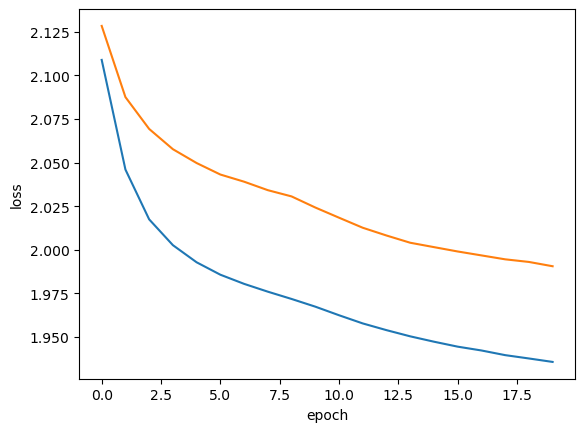

True

In [170]:


plt.plot(summary['steps'], summary['train_loss'])
plt.plot(summary['steps'], summary['val_loss'])


plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()
len(summary['steps']) == len(summary['train_loss'])

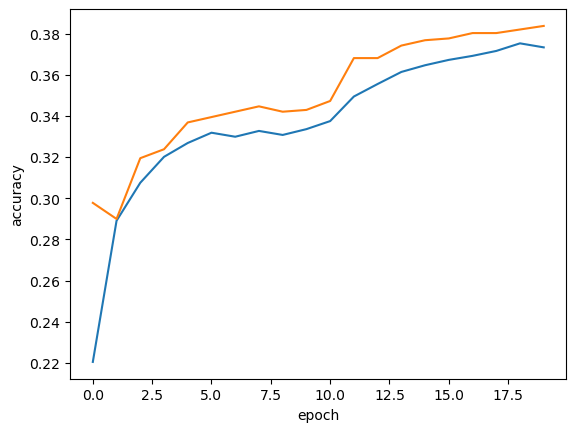

In [171]:

plt.plot(summary['steps'],summary['train_accuracy'],)
plt.plot( summary['steps'],summary['val_accuracy'],)

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()





# 1. problem: small accuracy:
## possible causes:

- needs fine-tuning hyperparameters ( takes time )
- features are not suitable ( takes experiments )





### next step: optimize hyperparameters, and make comparisons among different decisions 